<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3: Preload setup

Basic setup so results can utilize the full width of the screen.

In [1]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 4: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 5. Perform Data Cleaning

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [4]:
# Reference: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
# Observe the datatypes for each feature.

df.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                    float64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [5]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [6]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

In [7]:
df[['text']].sample(10)

,text
510733,corona is making me go insane. I had a 2 hour long conversation with my bts and exo poster last night
198914,RT @megirish2001: GOI order is binding on all Indians Sir.\n\nFatwa is not.\n\nDid not expect this from you @Javedakhtarjadu https://t.co/V5LXx…
375507,"RT @WWUTTcom: In an article yesterday from @DrMichaelLBrown, he said two charismatic prophets see a major ""shift"" coming with the corona vi…"
327161,"RT @WaqasGujjar229: Forget about religion cast or creed of human when they need help, people r wanting there are thousands of people out th…"
278683,RT @OpIndia_com: Coronavirus: Bollywood Singer Kanika Kapoor tests positive for COVID-19 for 5th time https://t.co/PCGXKU8IwI
756744,"RT @thesaralisa: This corona virus is unfortunate but really reveals a lot of people’s true colours - corporations, your favourite influen…"
412235,"RT @desimojito: Delhi Police release a video of its warning to senior members of Markaz, Nizamuddin to vacate Markaz &amp; follow lockdown guid…"
151243,RT @SilahAkiro: #HeavenIsCalling\nThere are things you can do because of folly and they humiliate you...\n\n~Like rebuking Corona Virus that i…
361451,RT @_sxphiee_: When boris and Prince Charles have somehow been diagnosed with and recovered from corona in the space of about a week
792416,RT @ctraywick: Ppl keep saying we'll see a corona baby boom in 9 months.... more likely we'll see a corona divorce boom\n https://t.co/f4TuS…


## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [8]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [9]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

Two samples of the original tweet dataframe to make sure we are on track.

In [10]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
371832,NaN,Tue Mar 31 15:30:28 +0000 2020,Repost covid covıd19 corona coronavirusontour Benuemusic World Bonezworld Bonezworldng Bonezworldmedia Bonezmusic,NaN,https://www.instagram.com/p/B-ZzBdxpoU2/?igshid=14bsqe0ox6s5b,0,1245010582086041600,NaN,0,0,en,NaN,False,0,0,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">Instagram</a>",#Repost @realmrlyriq\n• • • • • •\n#covid #covıd19 #corona #coronavirusontour Stay Healthy and Eat Right\n@bonezworldng\n#Benuemusic to the #World\n#Bonezworld #Bonezworldng #Bonezworldmedia #Bonezmusic https://t.co/PA4nMN2dXZ,https://twitter.com/Bonezworldmedia/status/1245010582086041600,Thu Apr 18 02:12:38 +0000 2019,Bonezworldmedia,False,"Welcome to Bonezworld\nWe blog, promote Songs and videos.\nWe hype artist.\nEmail us-Bonezworldng@gmail.com\nVisit our website below 👇",3040,635,743,0,Nigeria,Bonezworldmedia,Bonezworldmedia,2985,NaN,http://www.bonezworld.com,False,• • • • • • Stay Healthy and Eat Right@bonezworldng#Benuemusic to the #Bonezworld
454664,NaN,Tue Mar 31 17:24:28 +0000 2020,NaN,NaN,https://youtu.be/CqftFUINpyk,0,1245039272010317824,NaN,0,0,en,NaN,False,0,0,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",A Corona virus patient infected everyone | coronavirus | Korea | south k... https://t.co/MiaZJSztre via @YouTube,https://twitter.com/SonsShehed/status/1245039272010317824,Thu Jan 30 10:10:18 +0000 2020,SonsShehed,False,"Saeed Sons And Shehed Center\nLandhi no:4,karachi,pakistan\nSaeedsons.shehedcenter@gmail.com",0,14,3982,0,NaN,Saeed Sons And Shehed Center,SonsShehed,120,NaN,NaN,False,A Corona virus patient infected everyone | coronavirus | Korea | south k... via


## Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that might be full/partially not in English.

In [11]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



Function to test whether tweet is English with error handling.

In [12]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [13]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By filtering out non-English tweets.

In [14]:
print("There are " + str(len(dfOriginals)) + " tweets, and " + str(sum(dfOriginals.guessed_language)) + " ("+str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 2))+"%) tweets detected as English.")

There are 245389 tweets, and 232816 (94.88%) tweets detected as English.


# Step 6. Conduct Sentiment Analysis

Import NLTK library, load class and function for Sentiment Analysis.

In [15]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [16]:
dfOriginals['sentimentscore'] = dfOriginals.modified_text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [17]:
dfOriginals.sample(2)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
172008,LolZ 😂 ! Who did enter in Kashmir???? Who did the same in Palestine???? 🧐,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.7142}"
89503,"He continued, ""You know that's how 93% percent of people have caught Corona?!"" Then he went up to buy some lollies – weird – and got pissed off that he had to scan it himself. I'd never been so confused in my life.","{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'compound': -0.8475}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


reference: https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the dictionary into their own feature for easier data manipulation--especially the compound feature which will be used later.

In [18]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

Merge the dataframe with sentiment scores and the dataframe with the original tweets together, onto a new dataframe `dfOriginals_Analyzed`.

In [19]:
dfOriginals_Analyzed = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

Quick preview of modified text and compound on the merged dataframe.

In [20]:
dfOriginals_Analyzed.sample(10)[['modified_text','compound']]

,modified_text,compound
181799,"Wow... The sultan of secularism should tell why there's is need of Fatwa when the State and already issued an order of shutting down of all religious places? Ye jo aapka tweet hai na Javed saab, ye humare desh k secularism ki sachhai hai.",0.0000
478282,"Did a great job for us, thanks for everything and good luck for your next adventures. Maybe we can have our cerverza in Torrevieja after this Corona shit ❤️🇪🇸",0.8934
74820,Shirley must see this.,0.0000
401586,"Thank you so much Khabazela, one question, i saw in China they had a dedicated hospital for Corona Virus patients, is it like that here in SA. Thanks",0.8720
669494,You can't even prank someone on because corona keeps surprising us day in day out.,0.2732
6728,If people like you can’t not understand it’s for helalth and safety of the country . Then better stay Sushhh... bloody bunch of uneducated people .,0.6486
619038,Only a Damn Fool would use and if any company with 10+ employees didn't already have in place a way to talk via videotape long before this Corona Virus showed-up that is actually SECURE those people are Beyond Damn Idiots! Amazing the Idiocy of Americans sometimes!,-0.2385
540136,"Corona lockdown Day 1.0 income.0 business activity.3x feeding.Expenses for just today ,780.Data sub ,500Total cash spent ,280.And we have 13 more days to go 😭😭😭😭😭😭😭",0.0000
223700,"HIV+ not as hygienically conscious as HIV negatives, but depends on training you received, willingness to follow standards set in your home, and workplace. So corona's told to keep their standards intact and keep hands clean. personal hygiene is important to avoid contagion",0.4215
589038,I hate being stuck in the house corona please go awayyy,-0.5267


We binning based on compound scores
* -1 to -0.1 = negative 
* -0.1 to 0.1  = neutral
* 0.1 to 1 = positive

The threshold chosen is based on the paper "Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm"

Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [21]:
dfOriginals_Analyzed['sentiment_class_relaxed'] = pd.cut(dfOriginals_Analyzed['compound'], bins=[-1, -0.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals_Analyzed.sentiment_class_relaxed.value_counts()

neg    89051
pos    84039
neu    72299
Name: sentiment_class_relaxed, dtype: int64

# Step 7. Conduct Basic Analysis

Observing the correlation between variables.

In [22]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_friends_count,user_listed_count
favorite_count,1.000000,0.908576,0.165683,-0.001108,0.015366,0.007852,0.005575,0.051646
retweet_count,0.908576,1.000000,0.090025,-0.003071,0.015991,0.007261,0.007084,0.039251
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452,0.000535,0.032721,0.609057
compound,-0.001108,-0.003071,0.003693,1.000000,-0.022604,-0.028941,-0.006560,0.000249
user_statuses_count,0.015366,0.015991,0.116452,-0.022604,1.000000,0.326723,0.105958,0.128835
user_favourites_count,0.007852,0.007261,0.000535,-0.028941,0.326723,1.000000,0.100920,0.016049
user_friends_count,0.005575,0.007084,0.032721,-0.006560,0.105958,0.100920,1.000000,0.048344
user_listed_count,0.051646,0.039251,0.609057,0.000249,0.128835,0.016049,0.048344,1.000000


In [23]:
# Basic stats of each feature

dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_friends_count,user_listed_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01655,27468.30799,18028.51423,1284.43071,34.64758
std,384.21091,122.27732,250678.23602,0.47919,75560.36124,39592.12977,10409.72569,680.04372
min,0.00000,0.00000,0.00000,-0.99520,1.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,64.00000,-0.39760,1156.00000,510.00000,135.00000,0.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000,4200.00000,399.00000,1.00000
75%,1.00000,0.00000,1307.00000,0.36120,24616.00000,17807.00000,1038.00000,6.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000,1254400.00000,4322723.00000,202433.00000


Plot Distribution of sentiment scores

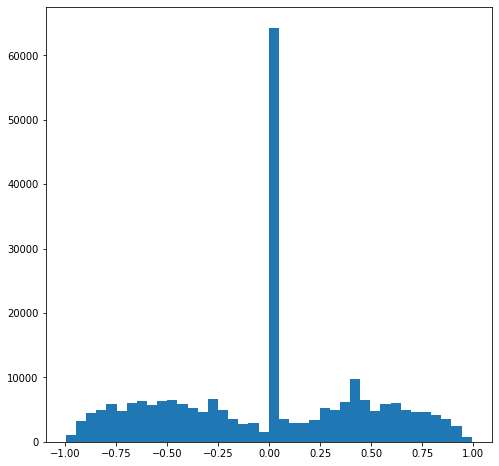

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8)) 
histo_plot = plt.hist(dfOriginals_Analyzed['compound'],bins=40)


(-1.1182944691568912,
 1.1129382929025038,
 -1.1162563432183583,
 1.1007741115818266)

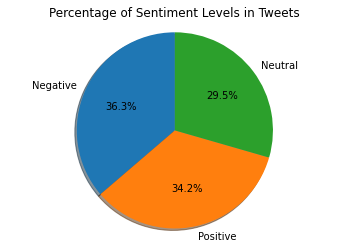

In [25]:
# Plot pie chart of the ratio of the sentiment categories
# 

fig1, ax1 = plt.subplots()
ax1.pie(dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().values, labels=dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().index.rename_categories(['Negative','Neutral','Positive']), autopct='%1.1f%%', shadow=True, startangle=90)
ax1.title.set_text("Percentage of Sentiment Levels in Tweets")
ax1.axis('equal')

# Step 8. Build Prediction Model for "Favourite Count" with Linear Regression

## Split Train and Test set

In [26]:
from sklearn import preprocessing
from sklearn import linear_model


# Defining
independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'

# Sample 80/20
trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

# Split and fit data
X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

# print Coefficient
print('Coefficient\tLabel\n===========================================')
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{: 4f}\t{}'.format(*el))

print(f"\nR^2-score (train set): {reg.score(X_train,Y_train):4f}")


Coefficient	Label
 2.536713	retweet_count
 0.000211	user_followers_count
 1.016376	compound
-0.000038	user_statuses_count
 0.000057	user_favourites_count
-0.000056	user_friends_count
-0.034559	user_listed_count

R^2-score (train set): 0.799859


Since this is a regression model with continous values, we use Mean Square Error (MSE), Root MSE, and R-square metrics to measure the performance of the model. 

reference: https://stackoverflow.com/questions/49103139/calculating-accuracy-scores-of-predicted-continuous-values

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R^2:\t\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")




Metrics
Mean Square Error (MSE): 33404.189046
Root MSE:		 182.768129
Mean Absolute Error:	 7.281756
R^2:			 0.873217
Adjusted R-Square:	 0.873199


Scatterplot to visually observe how well the model's prediction vs actual value.

Text(0.5, 0, 'Actual values (favorite_count)')

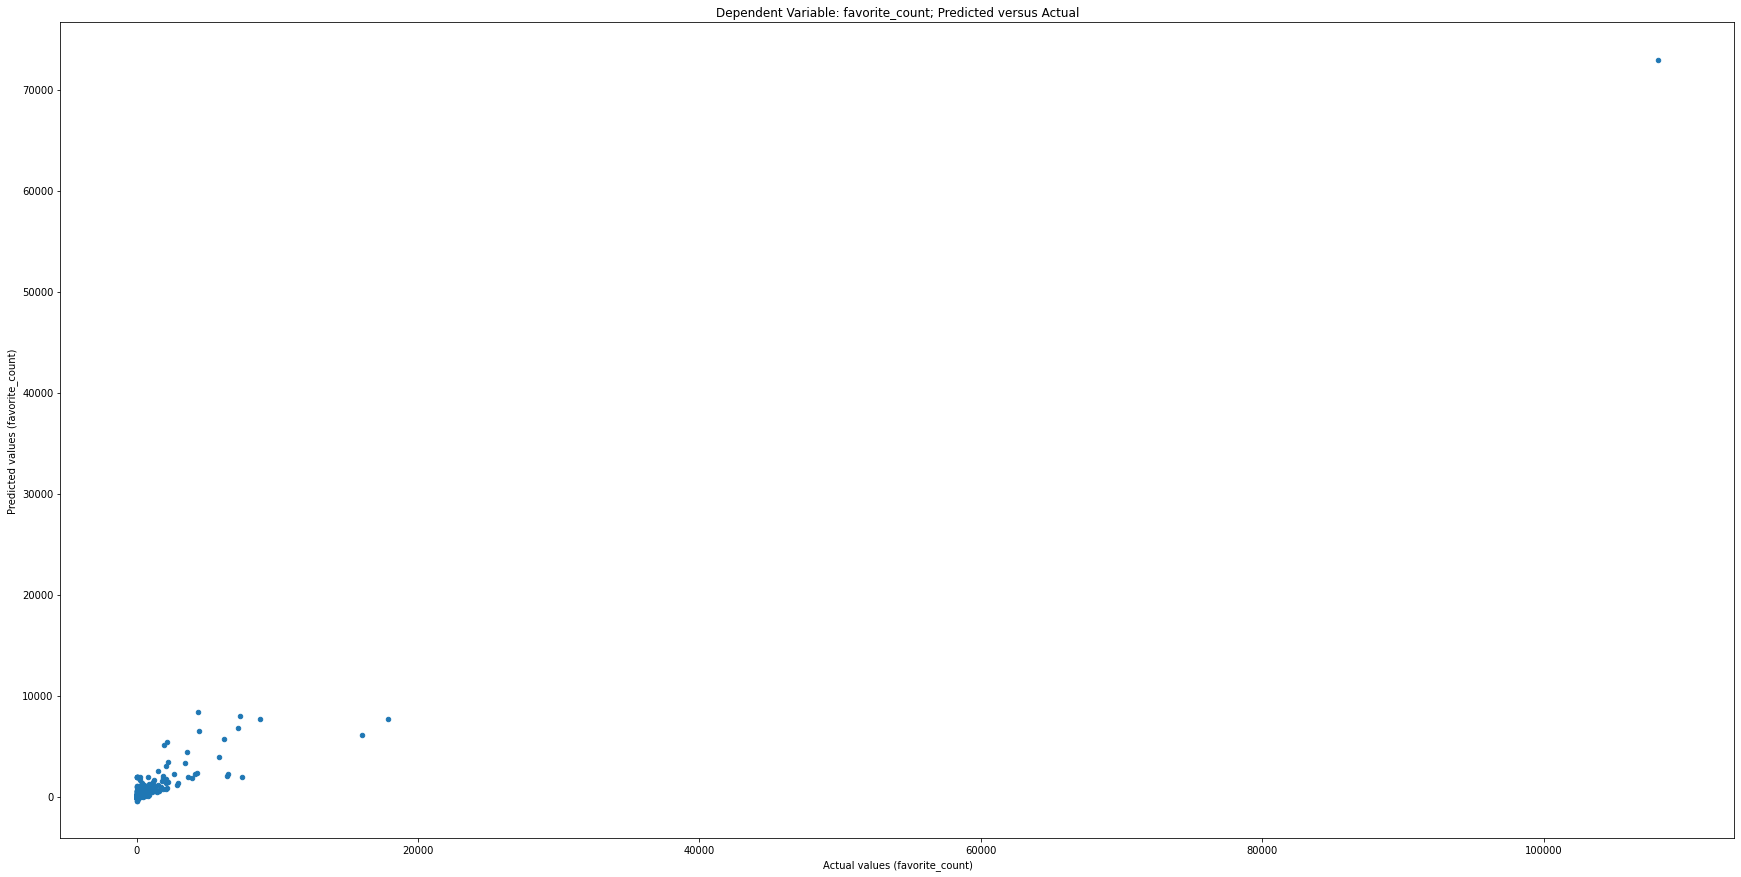

In [28]:
from numpy.polynomial.polynomial import polyfit
import numpy as np


plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")



Since our outliers are stretching the graph, we will limit the observation to 2-sigma (95%).

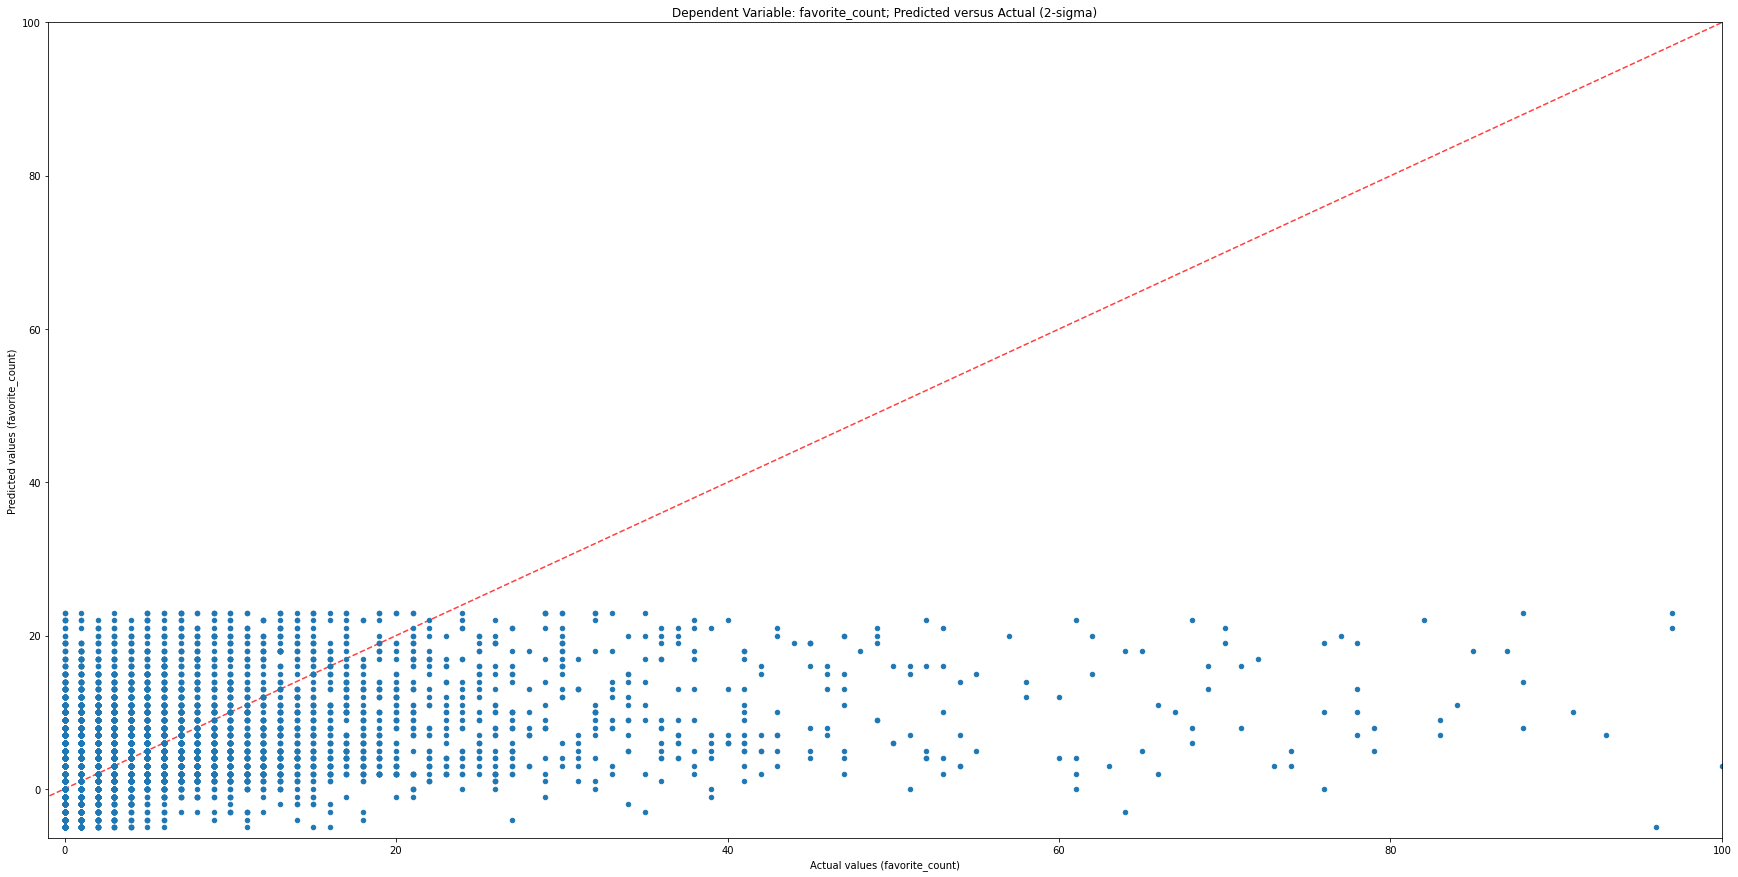

In [29]:
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.025), df_plot_1.predicted.quantile(0.975))]
# df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.0015), df_plot_1.predicted.quantile(0.9985))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")
plot_2.set_ylim(top=100)
plot_2.set_xlim(right=100)
plot_2.set_xlim(left=-1)




# b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
# plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

lims = [
    np.min([plot_2.get_xlim(), plot_2.get_ylim()]),  # min of both axes
    np.max([plot_2.get_xlim(), plot_2.get_ylim()]),  # max of both axes
]
plot_2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# Step 9. Build Prediction Model for "Retweet Count" with Linear Regression

## Split Train and Test set

In [30]:
# Repeating step 8 but with retweet_count as dependent variable.

from sklearn import preprocessing
from sklearn import linear_model

independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

# print("Coefficients: " + ', '.join(independent_variables))
# print(reg.coef_)
print('Coefficient\tLabel\n===========================================')
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{: 4f}\t{}'.format(*el))

print(f"\nR^2-score (train set): {reg.score(X_train,Y_train):4f}")


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)



mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R-Square:\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")


Coefficient	Label
 0.311235	favorite_count
-0.000055	user_followers_count
-0.449341	compound
 0.000013	user_statuses_count
-0.000014	user_favourites_count
 0.000025	user_friends_count
 0.009861	user_listed_count

R^2-score (train set): 0.791882

Metrics
Mean Square Error (MSE): 1234.588084
Root MSE:		 35.136706
Mean Absolute Error:	 1.967480
R-Square:		 0.934187
Adjusted R-Square:	 0.934178


Scatterplot of Predicted value vs Actual Value.

Text(0.5, 0, 'Actual values (retweet_count)')

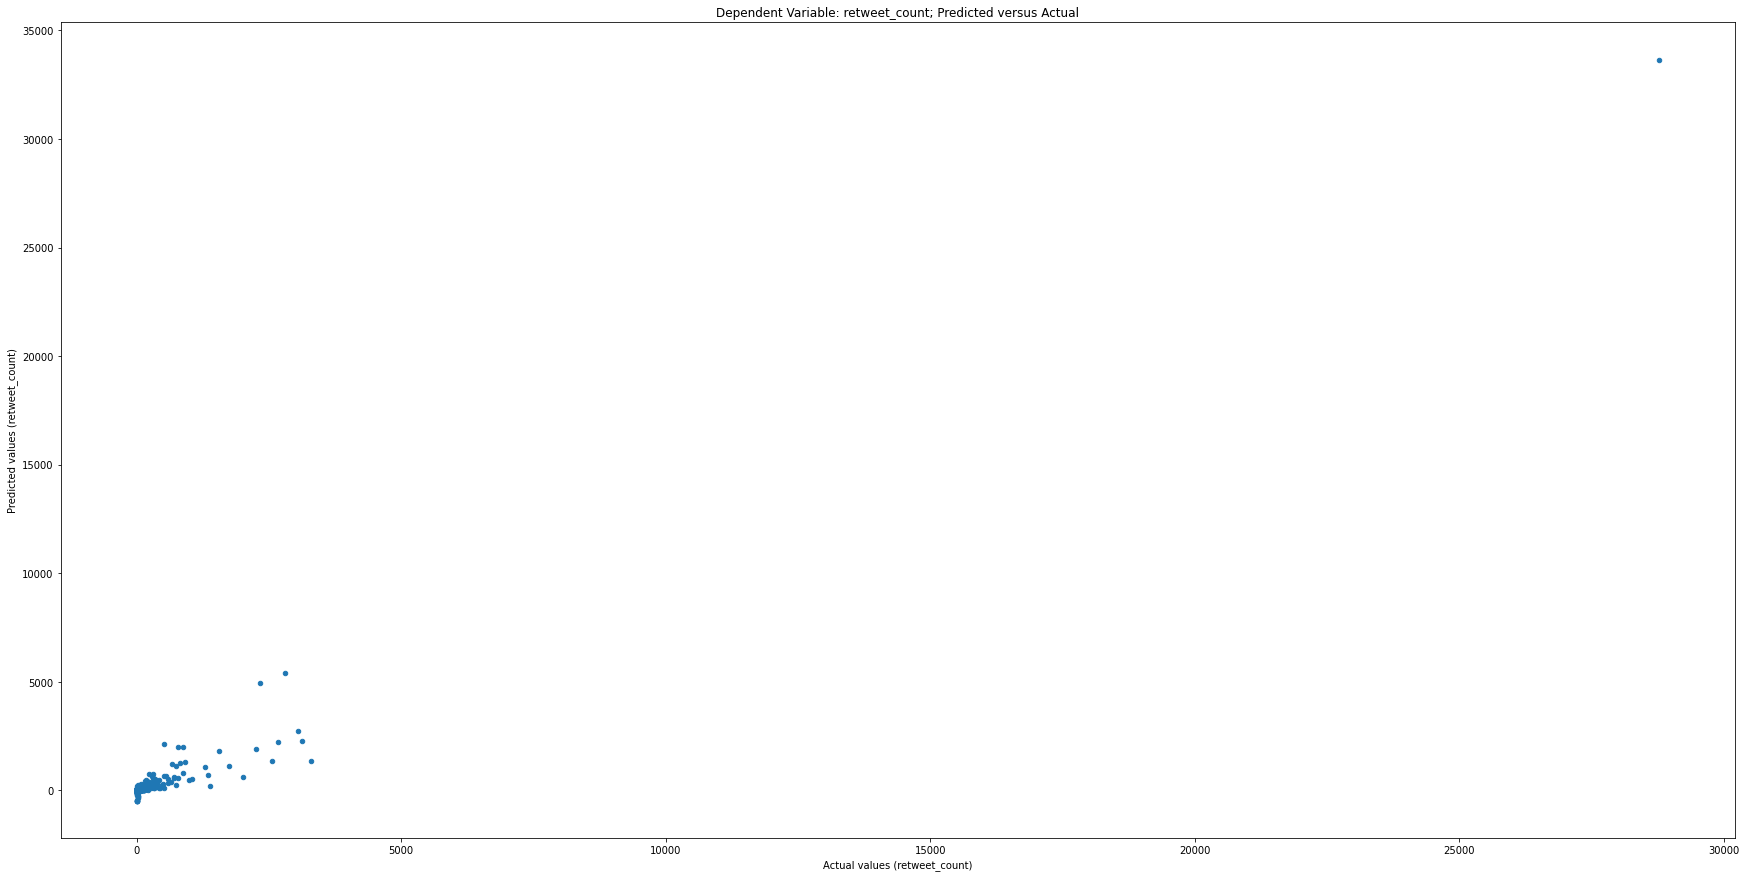

In [31]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")




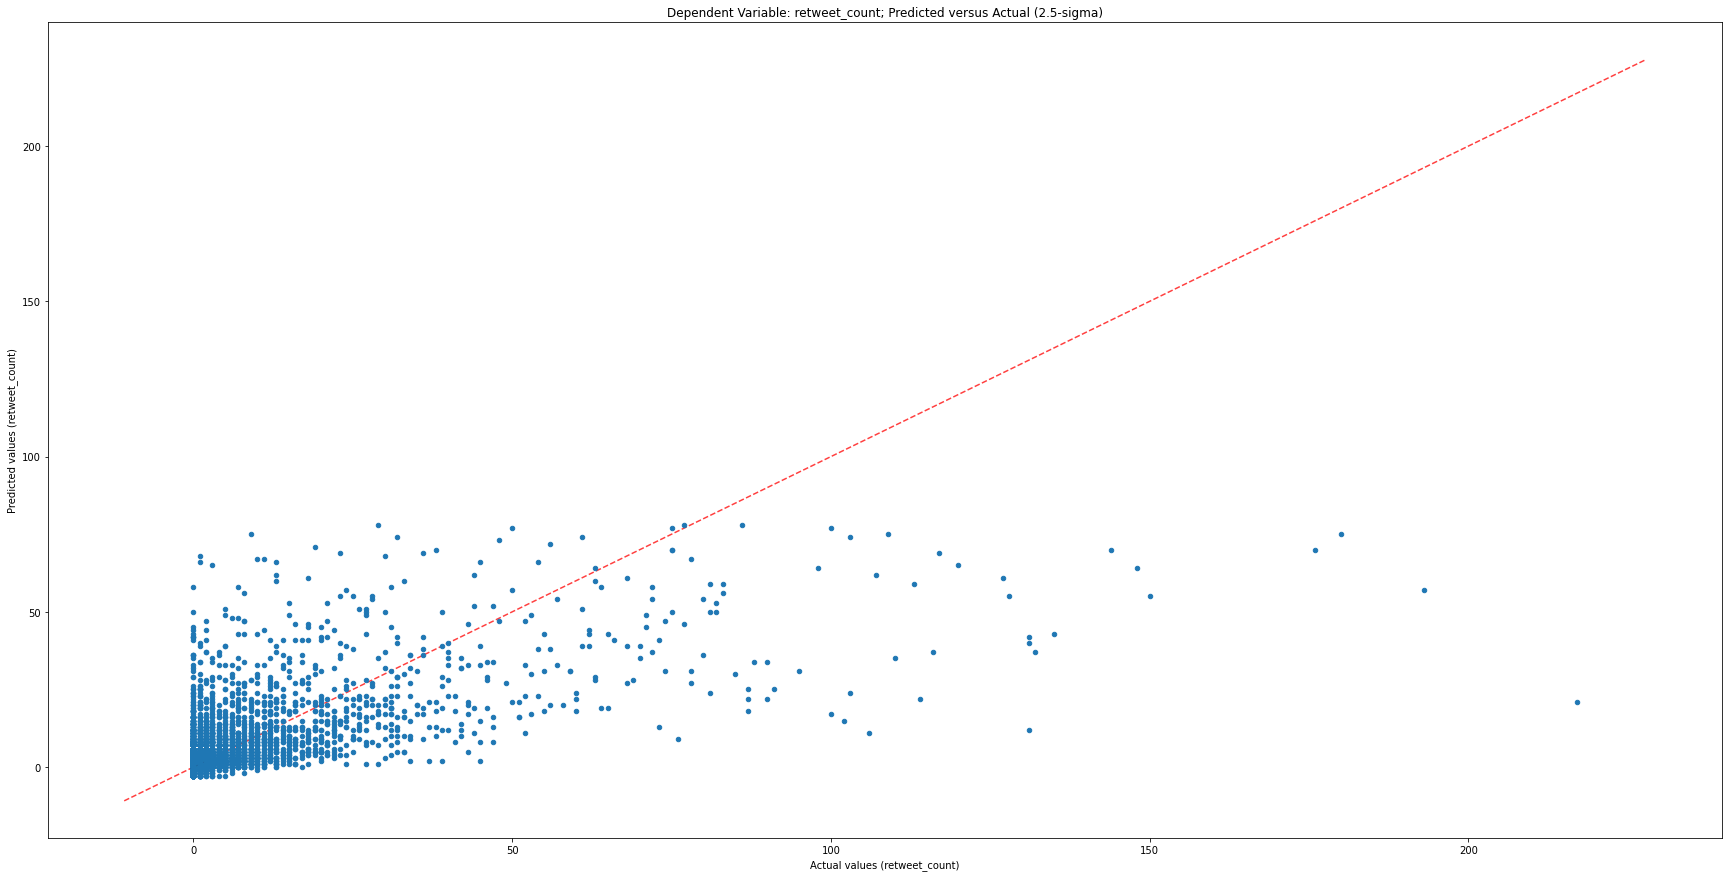

In [32]:
# Scatterplot covering 2.5-sigma.
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(.0031), df_plot_1.predicted.quantile(0.9969))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")

# b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
# plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

lims = [
    np.min([plot_2.get_xlim(), plot_2.get_ylim()]),  # min of both axes
    np.max([plot_2.get_xlim(), plot_2.get_ylim()]),  # max of both axes
]
plot_2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# Step 10: Build Linear Regression with k-Fold

Since the metrics we got from the previous regression consist of only one sampling, we should implement the same regression model using K-fold cross-validation in order to get more accurate metrics.

In [33]:
# K-fold - #1 favourite count as dependent
#
# References:
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
# https://stackoverflow.com/questions/57398411/next-always-gives-the-same-index-with-a-kfold-generator
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/
from sklearn.model_selection import KFold

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'


kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("MSE\t\t\tRMSE\t\t\tR-Square\n=============================================================================================")

# run each K-fold
for train_idx, test_idx in kf_result:
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)

  print(f"{mse:4f}\t\t{sqrt(mse):4f}\t\t{rsqr:4f}")

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print(f"{kfold_mse_total / kfold_n:4f}\t\t{kfold_rmse_total / kfold_n:4f}\t\t{kfold_rsqr_total / kfold_n:4f}")




Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
MSE			RMSE			R-Square
31564.218170		177.663216		0.877825
10521.044828		102.572145		0.704872
130028.329157		360.594411		0.378130
10211.723622		101.053073		0.782832
13119.346895		114.539718		0.930201

Average
39088.932535		171.284512		0.734772


In [34]:
# K-fold #2 Retweet as independent
#

from sklearn.model_selection import KFold


independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("MSE\t\t\tRMSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)

  print(f"{mse:4f}\t\t{sqrt(mse):4f}\t\t{rsqr:4f}")

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print(f"{kfold_mse_total / kfold_n:4f}\t\t{kfold_rmse_total / kfold_n:4f}\t\t{kfold_rsqr_total / kfold_n:4f}")





Dependent Variable: retweet_count
Independent Variables: ['favorite_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
MSE			RMSE			R-Square
1001.568224		31.647563		0.945563
798.111384		28.250865		0.605363
10974.758804		104.760483		0.685319
728.033332		26.982093		0.750776
666.921016		25.824814		0.959674

Average
2833.878552		43.493164		0.789339


# Step 11: Build Polynomial Regression

Here we attempt to fit our model onto a non-linear regression model--Polynomial regression model to see whether we are able to build a better fit of the model than linear regression.

R-squared values: 

Polynomial degree 1: test score=0.87
Polynomial degree 2: test score=0.72
Polynomial degree 3: test score=-5.57
Polynomial degree 6: test score=0.11


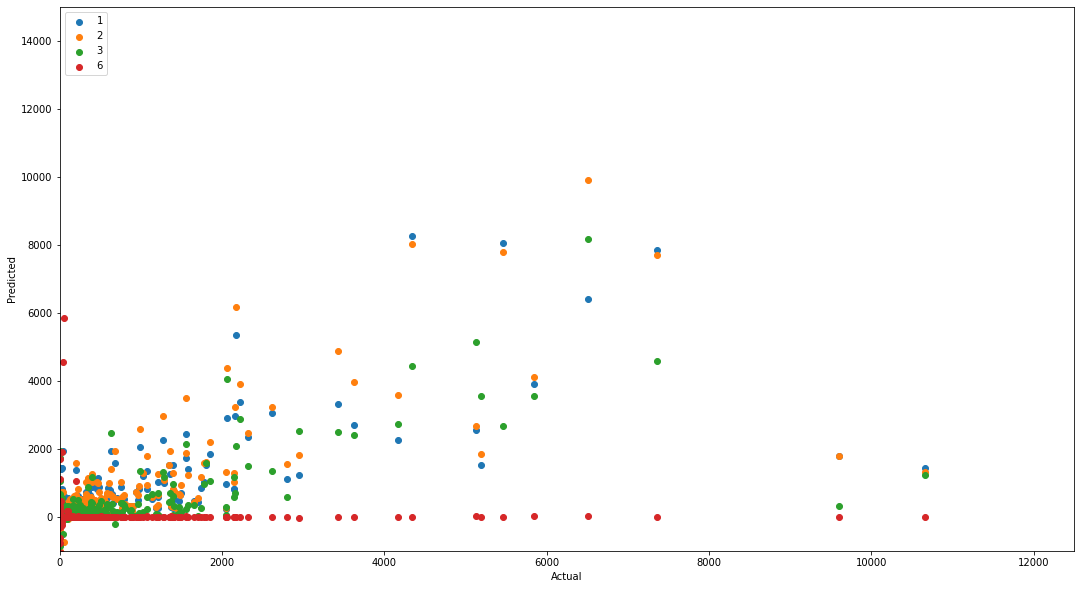

In [35]:
# POLYNOMIAL REGRESSION #1 favorite_count
#
# Reference
# https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'

degrees = [1, 2, 3, 6]


dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

R-squared values: 

Polynomial degree 1: test score=0.94
Polynomial degree 2: test score=0.08
Polynomial degree 3: test score=0.01
Polynomial degree 6: test score=-422.7


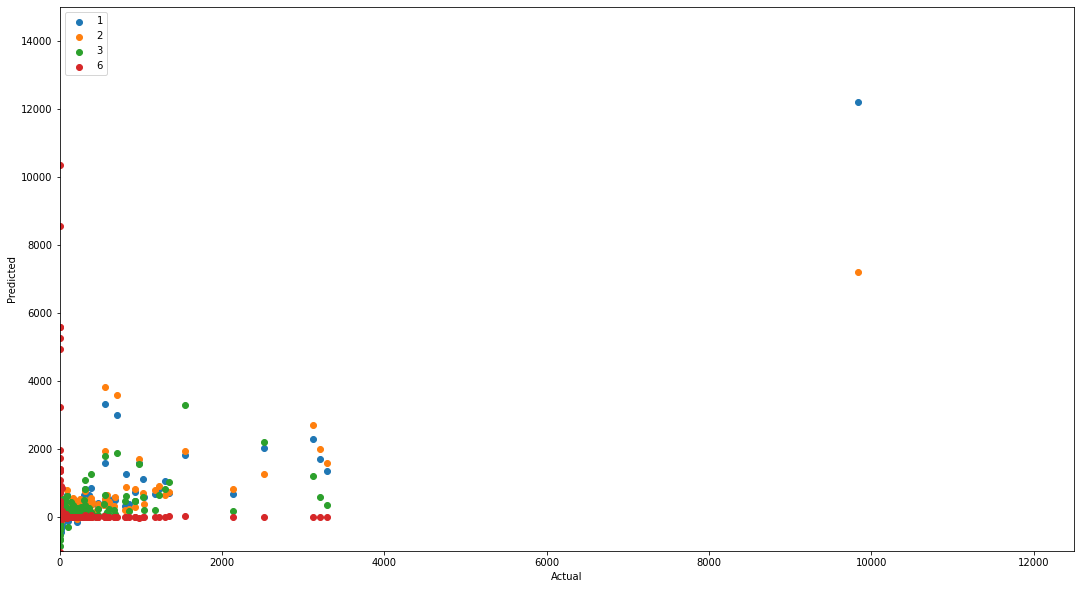

In [36]:
# POLYNOMIAL REGRESSION #2 retweet_count
#


independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    # train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

# Step 12: Build Polynomial Regression K-fold

In [37]:
import math

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'retweet_count'
# degrees = [1, 2 ]
degrees = [1, 2, 3, 6]
count = 0

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees)
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPolyKfold = dfOriginals_Analyzed

kf_result = kf.split(dfPolyKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Polynomial\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfPolyKfold.iloc[train_idx]
  testSet=dfPolyKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  y_test_pred = np.zeros((len(X_test), len(degrees)))

  for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    

    y_test_pred[:, i] = model.predict(X_test)

  
  
  for i, degree in enumerate(degrees):
    
    rsqr = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    mse = mean_squared_error(Y_test, y_test_pred[:, i])
    print("Degree {0}: \t\t{1} \t\t{2}".format(degree, sqrt(mse),rsqr))
    row = math.floor(count/len(degrees))
    kfold_mse_total.loc[ row,degree ] = mse
    kfold_rmse_total.loc[ row,degree] = sqrt(mse)
    kfold_rsqr_total.loc[row,degree] = rsqr
    # print(f"count: {count}  row: {row}\n{kfold_rsqr_total.loc[row]}")
    count += 1
    


  print("---------------------------------------------------------------------------------")

polykfold_overall_metrics = list(zip(degrees,kfold_rmse_total.mean(),kfold_rsqr_total.mean()))
print('Degree\tAverage RMSE\tAverage R^2'.format(*el))
for el in polykfold_overall_metrics:
  print('{}\t{: 4f}\t{: 4f}'.format(*el))



Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_verified']
K-fold: 5
Polynomial		Root MSE			R-Square
Degree 1: 		176.1003309179579 		0.88
Degree 2: 		283.8671924780902 		0.69
Degree 3: 		906.2368606263769 		-2.18
Degree 6: 		856.3979925552468 		-1.84
---------------------------------------------------------------------------------
Degree 1: 		101.57117876732413 		0.71
Degree 2: 		113.61553501192776 		0.64
Degree 3: 		164.8107158447843 		0.24
Degree 6: 		1067.8173629126154 		-30.98
---------------------------------------------------------------------------------
Degree 1: 		361.7648735168686 		0.37
Degree 2: 		578.1225176563707 		-0.6
Degree 3: 		10089.810890024544 		-485.89
Degree 6: 		38011377.335343964 		-6910168447.01
---------------------------------------------------------------------------------
Degree 1: 		106.07747474685985 		0.76
Degree 2: 		132.28407898975604 		0.63
Degree 3: 		429.97

In [38]:
# K-fold Poly #2 Retweet

import math

# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'retweet_count'
# degrees = [1, 2 ]
degrees = [1, 2, 3, 6]
count = 0

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees)
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
dfPolyKfold = dfOriginals_Analyzed

kf_result = kf.split(dfPolyKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Polynomial\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  trainSet=dfPolyKfold.iloc[train_idx]
  testSet=dfPolyKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  y_test_pred = np.zeros((len(X_test), len(degrees)))

  for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    

    y_test_pred[:, i] = model.predict(X_test)

  
  
  for i, degree in enumerate(degrees):
    
    rsqr = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    mse = mean_squared_error(Y_test, y_test_pred[:, i])
    print("Degree {0}: \t\t{1} \t\t{2}".format(degree, sqrt(mse),rsqr))
    row = math.floor(count/len(degrees))
    kfold_mse_total.loc[ row,degree ] = mse
    kfold_rmse_total.loc[ row,degree] = sqrt(mse)
    kfold_rsqr_total.loc[row,degree] = rsqr
    # print(f"count: {count}  row: {row}\n{kfold_rsqr_total.loc[row]}")
    count += 1
    


  print("---------------------------------------------------------------------------------")

polykfold_overall_metrics = list(zip(degrees,kfold_rmse_total.mean(),kfold_rsqr_total.mean()))
print('Degree\tAverage RMSE\tAverage R^2'.format(*el))
for el in polykfold_overall_metrics:
  print('{}\t{: 4f}\t{: 4f}'.format(*el))



Dependent Variable: retweet_count
Independent Variables: ['favorite_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_verified']
K-fold: 5
Polynomial		Root MSE			R-Square
Degree 1: 		30.619157472439177 		0.95
Degree 2: 		143.57465611146827 		-0.12
Degree 3: 		197.92059429558387 		-1.13
Degree 6: 		140.91449714880363 		-0.08
---------------------------------------------------------------------------------
Degree 1: 		27.778555948274388 		0.62
Degree 2: 		33.17703268992806 		0.46
Degree 3: 		44.99600146557491 		-0.0
Degree 6: 		1595.006459641652 		-1256.94
---------------------------------------------------------------------------------
Degree 1: 		105.01778633851833 		0.68
Degree 2: 		109.10569803537199 		0.66
Degree 3: 		1123.4793102354063 		-35.19
Degree 6: 		185441.21308761396 		-986024.03
---------------------------------------------------------------------------------
Degree 1: 		28.269222892920038 		0.73
Degree 2: 		47.405288929894574 		0.23
Degree 3: 		55.0

In [42]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/AndyLee-NLP.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AndyLee-NLP.ipynb to html
[NbConvertApp] Writing 777548 bytes to /content/drive/MyDrive/Colab Notebooks/AndyLee-NLP.html
